In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import parse_raw_to_csv
import os
import numpy as np
import seaborn as sns

#Just use set_theme() function of seaborn library for a nice looking appearance.
sns.set_theme()

df = pd.DataFrame()

for i in [1,2,5,8,13]:
    df_tmp = pd.DataFrame()
    for f in os.listdir("../../experiments/%d_fpga" % i):
        if any(f.endswith(e) for e in [".txt",".out"]) and any(f.startswith(s) for s in ["stream", "ra", "fft", "gemm"]):
            df_tmp = df_tmp.append(parse_raw_to_csv.parse_file_or_folder(os.path.join("../../experiments/%d_fpga" % i, f), parse_raw_to_csv.parse_map.values()))
    if os.path.exists("../../experiments/%d_fpga/u280" % i):
        for f in os.listdir("../../experiments/%d_fpga/u280" % i):
            if any(f.endswith(e) for e in [".txt",".out"]) and any(f.startswith(s) for s in ["stream", "ra", "fft", "gemm"]):
                df_tmp = df_tmp.append(parse_raw_to_csv.parse_file_or_folder(os.path.join("../../experiments/%d_fpga/u280" % i, f), parse_raw_to_csv.parse_map.values()))
    df_tmp["N"] = i
    df = df.append(df_tmp)

df["n"] = df["N"] * 2
df.loc[df["n"] == 2,"n"] = 1

df_tmp = pd.DataFrame()
for f in os.listdir("../../experiments/1_fpga_full"):
    if any(f.endswith(e) for e in [".txt",".out"]) and any(f.startswith(s) for s in ["stream", "ra", "fft", "gemm"]):
        df_tmp = df_tmp.append(parse_raw_to_csv.parse_file_or_folder(os.path.join("../../experiments/1_fpga_full", f), parse_raw_to_csv.parse_map.values()))
if os.path.exists("../../experiments/%d_fpga/u280" % i):
    for f in os.listdir("../../experiments/1_fpga_full/u280/"):
        if any(f.endswith(e) for e in [".txt",".out"]) and any(f.startswith(s) for s in ["stream", "ra", "fft", "gemm"]):
            df_tmp = df_tmp.append(parse_raw_to_csv.parse_file_or_folder(os.path.join("../../experiments/1_fpga_full/u280", f), parse_raw_to_csv.parse_map.values()))
df_tmp["N"] = 1
df_tmp["n"] = df_tmp["N"] * 2
df = df.append(df_tmp)
df["benchmark"] = df.index
df = df.apply(pd.to_numeric, errors='ignore')
df = df.reset_index()
#df = df.drop(df[(df["benchmark"] == "RandomAccess") & (df["size"]  > 1.073741e+09) & (df["n"]  > 1)].index)
df[df["benchmark"] == "RandomAccess"]["error"]

FileNotFoundError: [Errno 2] No such file or directory: '../../experiments/5_fpga/u280'

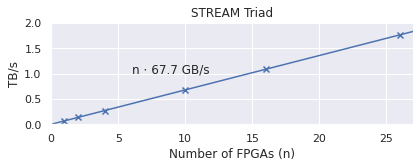

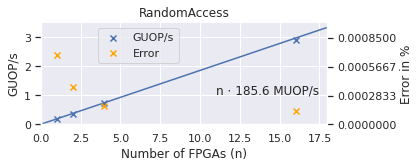

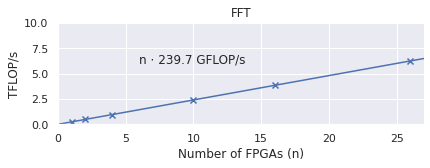

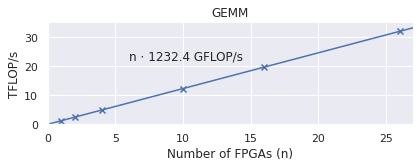

In [40]:
fig, stream = plt.subplots(1, figsize=(6,2.5))
stream.scatter(df[df["benchmark"] == "STREAM"]["n"], df[df["benchmark"] == "STREAM"]["triad_rate"]* 1.0e-6, label="Triad", marker="x")
stream.set_xlabel("Number of FPGAs (n)")
stream.set_ylabel("TB/s")
stream.set_title("STREAM Triad")
stream.set_ylim(0,2)
stream.set_xlim(0,27)
#stream.set_xscale("log")
values = df[df["benchmark"] == "STREAM"]["triad_rate"].values * 1.0e-6
count = df[df["benchmark"] == "STREAM"]["n"].values
stream.annotate("n ⋅ %.1f GB/s" % (values[0] * 1.0e3), (6,1))
stream.plot([0,27], [0, 27 * values[0]])
#stream.grid(which="major", linestyle="--", color="gray", axis="y")
stream.spines["right"].set_visible(False)
stream.spines["top"].set_visible(False)
fig.tight_layout()
fig.savefig("stream_scaling_performance.pdf")

fig, ra = plt.subplots(1, figsize=(6,2.5))
ra.scatter(df[df["benchmark"] == "RandomAccess"]["n"], df[df["benchmark"] == "RandomAccess"]["gops"], label="GUOP/s", marker="x")
ra.set_xlabel("Number of FPGAs (n)")
ra.set_ylabel("GUOP/s")
ra.set_title("RandomAccess")
ra.set_ylim(0,3.5)
ra.set_xlim(0,18)
values = df[df["benchmark"] == "RandomAccess"]["gops"].values
count = df[df["benchmark"] == "RandomAccess"]["n"].values
ra.plot(np.linspace(0,18), np.linspace(0,18) * values[0])
#ra.annotate("%.1f" % values[0], (count[0] + 0.5, values[0] - 100))
#ra.annotate("%.1f" % values[1], (count[1] + 0.5, values[1] - 130))
#ra.annotate("%.1f" % values[2], (count[2] - 0.5, values[2] - 130 ))
#ra.annotate("%.1f" % values[3], (count[3] - 1, values[3] - 130))
#ra.annotate("%.1f" % values[4], (count[4] - 1, values[4] - 130))

ra_error = ra.twinx()
ra_error.scatter(df[df["benchmark"] == "RandomAccess"]["n"], df[df["benchmark"] == "RandomAccess"]["error"], color="orange", label="Error", marker="x")
ra_error.set_ylabel("Error in %")
ra_error.set_ylim(0,1.0e-3)
ra_error.set_yticks(np.linspace(0, 0.00085, 4))
#ra_error.set_yticks([6.0e-3/0.75 * 0.2,6.0e-3/0.75 * 0.4,6.0e-3/0.75 * 0.6])
#ra.plot([0,18], [0.440,.440], linestyle="--", color="darkblue", alpha=0.7, label="440 MUOP/s")
#ra.grid(which="major", linestyle="--", color="gray", axis="y")
ra.spines["top"].set_visible(False)
ra_error.spines["top"].set_visible(False)
ra_error.annotate("n ⋅ %.1f MUOP/s" % (values[0] * 1.0e3), (11,0.0003))
ra_error.grid(None)

lines, labels = ra.get_legend_handles_labels()
lines2, labels2 = ra_error.get_legend_handles_labels()
ra_error.legend(lines + lines2, labels + labels2, loc="upper right", bbox_to_anchor=(0.5,1.0))
fig.tight_layout()
fig.savefig("ra_scaling_performance.pdf")
fig, fft = plt.subplots(1, figsize=(6,2.5))

fft.scatter(df[df["benchmark"] == "FFT"]["n"], df[df["benchmark"] == "FFT"]["best_flops"] * 1.0e-3, marker="x")
fft.set_xlabel("Number of FPGAs (n)")
fft.set_ylabel("TFLOP/s")
fft.set_title("FFT")
fft.set_ylim(0,10)
fft.set_xlim(0,27)
values = df[df["benchmark"] == "FFT"]["best_flops"].values * 1.0e-3
fft.annotate("n ⋅ %.1f GFLOP/s" % (values[0] * 1.0e3), (6,6))
#fft.annotate("%.2f" % values[0], (df[df["benchmark"] == "FFT"]["n"][0] + 1, values[0] - 0.3))
#fft.annotate("%.2f" % values[1], (df[df["benchmark"] == "FFT"]["n"][1] + 1, values[1] - 0.3))
#fft.annotate("%.2f" % values[2], (df[df["benchmark"] == "FFT"]["n"][2] +1, values[2] - 0.3))
#fft.annotate("%.2f" % values[3], (df[df["benchmark"] == "FFT"]["n"][3] - 1, values[3]- 1))
fft.plot([0,27], [0, 27 * values[0]])
#fft.grid(which="major", linestyle="--", color="gray", axis="y")
fft.spines["right"].set_visible(False)
fft.spines["top"].set_visible(False)
fig.tight_layout()
fig.savefig("fft_scaling_performance.pdf")
fig, gemm = plt.subplots(1, figsize=(6,2.5))

gemm.scatter(df[df["benchmark"] == "GEMM"]["n"], df[df["benchmark"] == "GEMM"]["gflops"] * 1.0e-3, marker="x")
gemm.set_xlabel("Number of FPGAs (n)")
gemm.set_ylabel("TFLOP/s")
gemm.set_title("GEMM")
gemm.set_ylim(0,35)
gemm.set_xlim(0,27)
#gemm.set_xscale("log")
values = df[df["benchmark"] == "GEMM"]["gflops"].values * 1.0e-3
gemm.annotate("n ⋅ %.1f GFLOP/s" % (values[0] * 1.0e3), (6,22))
#gemm.annotate("%.2f" % values[0], (df[df["benchmark"] == "GEMM"]["n"][0] + 1, values[0] - 0.3))
#gemm.annotate("%.2f" % values[1], (df[df["benchmark"] == "GEMM"]["n"][1] + 1, values[1] - 0.3))
#gemm.annotate("%.2f" % values[2], (df[df["benchmark"] == "GEMM"]["n"][2] +1, values[2] - 0.3))
#gemm.annotate("%.2f" % values[3], (df[df["benchmark"] == "GEMM"]["n"][3] - 1, values[3]- 1))
gemm.plot([0,27], [0, 27 * values[0]])
#gemm.grid(which="major", linestyle="--", color="gray", axis="y")
gemm.spines["right"].set_visible(False)
gemm.spines["top"].set_visible(False)

fig.tight_layout()

#fig.savefig("gemm_scaling_performance.pdf")